In [95]:
from datetime import datetime
from typing import Any
import pandas as pd
import numpy as np
import sys
from pathlib import Path

from config import model_dir
from sklearn.base import BaseEstimator

sys.path.append("../src")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import plotly.express as px
import chart_studio.plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from config import data_dir
from data.load import FileDataLoader, DatasetFilename
from tqdm import tqdm

# auto reload all modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

PLOTS_DIR = Path('../plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
class PlotMng:
    
    @staticmethod
    def save_plot(fig, plotname: str, transparent=True) -> None:
        """Save interactive plot to HTML."""
        if transparent:
            fig = PlotMng.transparent_background(fig)
        pio.write_html(fig, file=PLOTS_DIR/plotname, auto_open=True)
        
    @staticmethod
    def transparent_background(fig):
        """Save interactive plot to HTML."""
        fig.update_layout({
            "plot_bgcolor": "rgba(0, 0, 0, 0)",
            "paper_bgcolor": "rgba(0, 0, 0, 0)",
        })
        return fig

# Naive Model

No Machine Learning.

Get a mean default rate for every column category (create bins for numeric columns). Predict default probability as an average of all means (equally weighted).

Add: factor by category frequency.

In [5]:
# get a list fo available datasets
data_io = FileDataLoader()
data_io.list_available()

['applications',
 'bureau_balance',
 'bureau',
 'credit_card_balance',
 'installments_payments',
 'previous_applications',
 'cash_balance']

In [6]:
for d in tqdm(['applications']):
    data_io.load_dataset(d)

  0%|                                                                                                                                                                                                                                                     | 0/1 [00:00<?, ?it/s]2022-06-07 21:26:42 logger [619] DEBUG {'process': 'load_dataset', 'message': 'Started.', 'args': {}}
2022-06-07 21:26:45 logger [619] DEBUG {'process': 'load_dataset', 'message': 'Success.', 'elapsed_seconds': 3.289}
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


In [10]:
data_io.list_loaded()

['applications']

In [9]:
df = data_io['applications']

# Creating Bins

In [43]:
col = 'amt_income_total'
data = df[['target', col]]
q = min(MAX_BINS, df[col].nunique())
q

20

In [49]:
# apply and save qcut bins
binned, bins_ = pd.qcut(
    df[col], 20, duplicates="drop", retbins=True, labels=False
)

data['binned'] = binned

/tmp/ipykernel_619/2527809487.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['binned'] = binned


In [45]:
len(bins_)

18

In [46]:
bins_

array([2.5650e+04, 6.7500e+04, 8.1000e+04, 9.0000e+04, 9.9000e+04,
       1.1250e+05, 1.2600e+05, 1.3500e+05, 1.4715e+05, 1.5750e+05,
       1.6200e+05, 1.8000e+05, 2.0250e+05, 2.2500e+05, 2.3400e+05,
       2.7000e+05, 3.3750e+05, 1.1700e+08])

In [47]:
binned.value_counts().sort_index()

0     21266
1     12125
2     24531
3      5749
4     36907
5     11507
6     37342
7      4333
8     29295
9      1825
10    30704
11    20389
12    24420
13      992
14    18965
15    13126
16    14035
Name: amt_income_total, dtype: int64

In [50]:
data

,target,amt_income_total,binned
0,1,202500.0,11
1,0,270000.0,14
2,0,67500.0,0
3,0,135000.0,6
4,0,121500.0,5
...,...,...,...
307506,0,157500.0,8
307507,0,72000.0,1
307508,0,153000.0,8
307509,1,171000.0,10


In [84]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

for p in pairwise(bins_):
    print(list(p))

[25650.0, 67500.0]
[67500.0, 81000.0]
[81000.0, 90000.0]
[90000.0, 99000.0]
[99000.0, 112500.0]
[112500.0, 126000.0]
[126000.0, 135000.0]
[135000.0, 147150.0]
[147150.0, 157500.0]
[157500.0, 162000.0]
[162000.0, 180000.0]
[180000.0, 202500.0]
[202500.0, 225000.0]
[225000.0, 234000.0]
[234000.0, 270000.0]
[270000.0, 337500.0]
[337500.0, 117000000.0]


In [98]:
pd.Series([np.random.choice([1,-1]) for i in range(1000)]).value_counts()

 1    501
-1    499
dtype: int64

<AxesSubplot:>

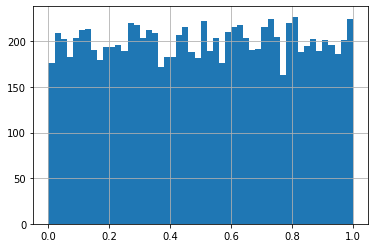

In [114]:
pd.Series([np.random.uniform(0,1) for i in range(10000)]).hist(bins=50)

In [120]:
data['x'] = data['amt_income_total']
data['y'] = [np.random.uniform(0,1) for i in range(len(data))]
data.head(3)

/tmp/ipykernel_619/1480360766.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_619/1480360766.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,target,amt_income_total,binned,x,y
0,1,202500.0,11,202500.0,0.329073
1,0,270000.0,14,270000.0,0.736166
2,0,67500.0,0,67500.0,0.009686


In [161]:
dr_x = []
dr_y= []

for i,p in enumerate(pairwise(bins_[:-1])):
    #print(i, p, np.mean(p), data.query('binned == @i').target.mean())
    dr_x.append(np.mean(p))
    dr_y.append(data.query('binned == @i').target.mean())
    
print(dr_x)
print(dr_y)

[46575.0, 74250.0, 85500.0, 94500.0, 105750.0, 119250.0, 130500.0, 141075.0, 152325.0, 159750.0, 171000.0, 191250.0, 213750.0, 229500.0, 252000.0, 303750.0]
[0.07885827141916675, 0.08725773195876288, 0.08148872854755208, 0.0854061575926248, 0.08719213157395617, 0.09003215434083602, 0.08331101708531947, 0.09000692360950842, 0.08707970643454514, 0.07561643835616438, 0.0842235539343408, 0.07979793025651086, 0.07661752661752662, 0.06955645161290322, 0.07044555760611652, 0.0648331555690995]


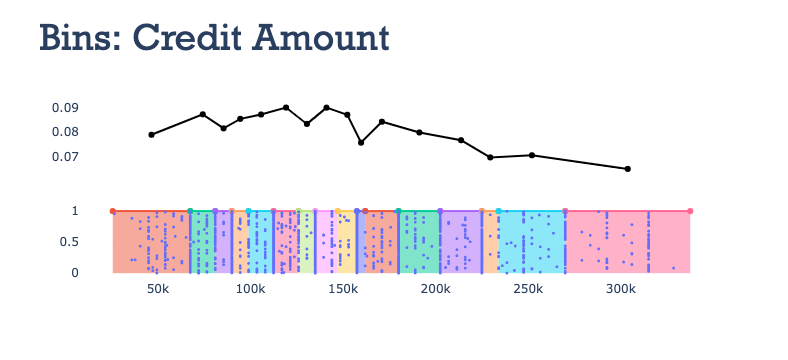

In [193]:
#fig = go.Figure()
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# Row 0: Bins and scatter
row1 = px.scatter(data.query('amt_income_total < 337500').sample(2000),
                 x='x', y='y', title='Credit Amount Bins')
fig.append_trace(row1.data[0], row=2, col=1)
for p in pairwise(bins_[:-1]):
    fig.add_trace(go.Scatter(x=p, y=[1, 1], fill='tozeroy'), row=2, col=1)


# Row 1: Mean Default Rate
fig.add_trace(go.Scatter(x=dr_x, y=dr_y, marker_color='black'), row=1, col=1)
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))

fig.update_layout(
        title='Bins: Credit Amount',
        title_font_family="Rockwell",
        title_font_size=35,
        showlegend=False,
        yaxis=dict(title=''),
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell",
        ))
PlotMng.save_plot(fig, '2_credit_amount_bins.html')
fig

## 1. Numeric Categories

In [194]:
MAX_BINS = 20

bins_dict: dict = dict()
bins_map: dict = dict()

for col in ['amt_income_total']:#tqdm(df.select_dtypes("number").drop(["sk_id_curr", "target"], axis=1).columns):
    # use 20 bins if number of unique valeus exceeds 20
    q = min(MAX_BINS, df[col].nunique())

    # apply and save qcut bins
    binned, bins_ = pd.qcut(
        df[col], q, duplicates="drop", retbins=True, labels=False
    )

    bins_dict[col] = bins_
    bins_map[col] = df.groupby(binned).target.mean()

In [196]:
# list of bin edges: len(bins_) = x => x-1 bins
bins_dict

{'amt_income_total': array([2.5650e+04, 6.7500e+04, 8.1000e+04, 9.0000e+04, 9.9000e+04,
        1.1250e+05, 1.2600e+05, 1.3500e+05, 1.4715e+05, 1.5750e+05,
        1.6200e+05, 1.8000e+05, 2.0250e+05, 2.2500e+05, 2.3400e+05,
        2.7000e+05, 3.3750e+05, 1.1700e+08])}

In [197]:
# binned == x => val between bins_[x] and bins_[x+1]
binned

0         11
1         14
2          0
3          6
4          5
          ..
307506     8
307507     1
307508     8
307509    10
307510     8
Name: amt_income_total, Length: 307511, dtype: int64

In [198]:
# mean default rate for every bin
bins_map

{'amt_income_total': amt_income_total
 0     0.078858
 1     0.087258
 2     0.081489
 3     0.085406
 4     0.087192
 5     0.090032
 6     0.083311
 7     0.090007
 8     0.087080
 9     0.075616
 10    0.084224
 11    0.079798
 12    0.076618
 13    0.069556
 14    0.070446
 15    0.064833
 16    0.058140
 Name: target, dtype: float64}

In [205]:
MAX_BINS = 20

bins_dict: dict = dict()
bins_map: dict = dict()

for col in tqdm(df.select_dtypes("number").drop(["sk_id_curr", "target"], axis=1).columns):
    # use 20 bins if number of unique valeus exceeds 20
    q = min(MAX_BINS, df[col].nunique())

    # apply and save qcut bins
    binned, bins_ = pd.qcut(
        df[col], q, duplicates="drop", retbins=True, labels=False
    )

    bins_dict[col] = bins_
    bins_map[col] = df.groupby(binned).target.mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:01<00:00, 59.81it/s]


## 2. Categorical

In [202]:
CAT_COLS = df.select_dtypes(object).columns
CAT_COLS

Index(['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty',
       'name_type_suite', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type', 'occupation_type',
       'weekday_appr_process_start', 'organization_type', 'fondkapremont_mode',
       'housetype_mode', 'wallsmaterial_mode', 'emergencystate_mode'],
      dtype='object')

In [203]:
cat_map = dict()
for col in CAT_COLS:
    cat_map[col] = df.groupby(col).mean().target

## 3. Predicting Prob(Default)

In [208]:
DEFAULT_AVG = df.target.mean()
DEFAULT_AVG

0.08072881945686496

In [213]:
def get_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.select_dtypes("number")

def get_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.select_dtypes(object)

In [220]:
def predict_proba(X, numeric_only:bool=False) -> pd.DataFrame:
    X_copy = X.drop('sk_id_curr', axis=1).copy()
    
    # numeric
    for col in get_numeric_columns(X_copy).columns:
        X_copy[col] = (
            pd.cut(
                X[col], bins=bins_dict[col], labels=False, include_lowest=True
            )
            .map(bins_map[col])
            .fillna(DEFAULT_AVG)
        )
        
    if not numeric_only:
        # categorical
        for col in get_categorical_columns(X_copy).columns:
            X_copy[col] = X_copy[col].map(cat_map[col]).fillna(DEFAULT_AVG)

        # mean
        prob_default = X_copy.mean(1)
    else:
        prob_default = get_numeric_columns(X_copy).mean(1)

    return prob_default

In [224]:
X = df.drop('target', axis=1)
preds = predict_proba(X)
preds

0         0.084267
1         0.074634
2         0.080222
3         0.081205
4         0.080672
            ...   
307506    0.076231
307507    0.079458
307508    0.075813
307509    0.081386
307510    0.077257
Length: 307511, dtype: float64

<AxesSubplot:>

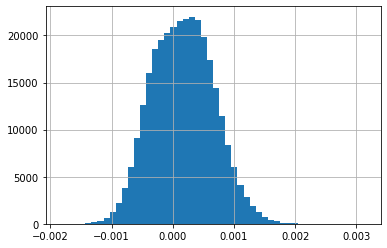

In [225]:
(preds - predict_proba(X, True)).hist(bins=50)

## 4. Analysis

In [ ]:
preds = predict_proba(X)

# Putting It Together

In [8]:
class NaiveEstimator(BaseEstimator):
    """Estimator that predicts an average probability of default given column bins."""

    DROP_COLS = ["sk_id_curr"]

    @classmethod
    def name(cls) -> str:
        return "naive_estimator"

    def __init__(self, margin: float = 0):
        self.bins_dict: dict = dict()
        self.bins_map: dict = dict()

        self.margin = 0
        self.is_fit = False

    @staticmethod
    def get_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
        """Get a subset of data only with numeric columns."""
        return df.select_dtypes("number").drop(NaiveEstimator.DROP_COLS, axis=1)

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        """Create bins for all numeric columns and save default rate for each bin."""
        df = X.copy()
        df["target"] = y

        for col in NaiveEstimator.get_numeric_columns(X).columns:
            # use 20 bins if number of unique valeus exceeds 20
            if X[col].nunique() < 20:
                q = X[col].nunique()
            else:
                q = 20

            # apply and save qcut bins
            binned, bins_ = pd.qcut(
                X[col], q, duplicates="drop", retbins=True, labels=False
            )

            self.bins_dict[col] = bins_
            self.bins_map[col] = df.groupby(binned).target.mean()
        self.is_fit = True

    def predict_proba(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Get average default rate for each column.

        Return average of all columns.
        """
        X_copy = X.copy()
        for col in NaiveEstimator.get_numeric_columns(X).columns:
            X_copy[col] = (
                pd.cut(
                    X[col], bins=self.bins_dict[col], labels=False, include_lowest=True
                )
                .map(self.bins_map[col])
                .fillna(DEFAULT_THRESH)
            )

        prob_default = NaiveEstimator.get_numeric_columns(X_copy).mean(1)

        probs = prob_default > DEFAULT_THRESH * (1 + self.margin)
        return probs

    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        """Return 1 if expect default, 0 otherwise."""

        probs = self.predict_proba(X)
        return probs.astype(int)